# Natural Language Inference with BERT

In [1]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFAutoModel
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import gc

2022-12-27 15:02:06.766736: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-27 15:02:06.766860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Configuration

In [2]:
class CFG:
    batch_size = 128
    sequence_length = 128

## Distribution Strategy

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    CFG.batch_size = strategy.num_replicas_in_sync * 16
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

2022-12-27 15:02:15.286281: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-27 15:02:15.289206: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-27 15:02:15.289244: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-27 15:02:15.289273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5bc2814a58eb): /proc/driver/nvidia/version does not exist
2022-12-27 15:02:15.293196: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


## Load data

In [4]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


## Load Pretrained model

In [5]:
with strategy.scope():
    model_roBerta ='joeddav/xlm-roberta-large-xnli'
    tokenizer = AutoTokenizer.from_pretrained(model_roBerta)
    encoder = TFAutoModel.from_pretrained(model_roBerta)
    gc.collect()

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


## Load MNLI dataset
You can learn more about this dataset [here](https://huggingface.co/datasets/multi_nli).

In [6]:
def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

In [7]:
mnli = load_mnli()
mnli

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,en
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,en
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,en
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,en


## Create TensorFlow dataset

In [8]:
def bert_encode(df, tokenizer):    
    batch_premises = df['premise'].tolist()
    batch_hypothesis = df['hypothesis'].tolist()

    tokens = tokenizer(
        batch_premises, 
        batch_hypothesis, 
        max_length = CFG.sequence_length,
        truncation=True, 
        padding='max_length',
        add_special_tokens=True, 
        return_attention_mask=True,
        return_tensors='tf'
    )
    inputs = {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }
    if "label" in df.keys():
        inputs["label"] = df["label"]
    return inputs

def preprocess(features):
    labels = features.pop("label")
    return features, labels
def make_dataset(df, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices((df))
    if mode == "train":
        ds = ds.shuffle(256)
    ds = ds.batch(CFG.batch_size)
    ds = ds.map(preprocess)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE).repeat()
    return ds

In [9]:
%%time
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=2)
train_data=pd.concat([train_data, mnli.loc[:100000]], axis=0)
train_input = bert_encode(train_data, tokenizer)
valid_input = bert_encode(valid_data, tokenizer)
train_ds = make_dataset(train_input)
valid_ds = make_dataset(valid_input, mode="valid")

CPU times: user 37.6 s, sys: 2.67 s, total: 40.3 s
Wall time: 15.3 s


Take a look at how tensor of training data look like.

In [10]:
for item in train_ds.take(1):
    print(item)

({'input_ids': <tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[     0, 177372,   6365, ...,      1,      1,      1],
       [     0,  47482,  33348, ...,      1,      1,      1],
       [     0,    581,   7515, ...,      1,      1,      1],
       ...,
       [     0,    756,   1836, ...,      1,      1,      1],
       [     0,   1650,  15673, ...,      1,      1,      1],
       [     0,  10160,      4, ...,      1,      1,      1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(128, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 2, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 1, 0, 0, 1,
       2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2,

## Calculate class weight

The dataset is relatively balanced. However I would like to add class_weight parameter in keras training method. This still can improve score a litte bit.

2022-12-27 15:06:13.103233: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 27786, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1672153573.099798449","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 27786, Output num: 2","grpc_status":3}


<AxesSubplot:>

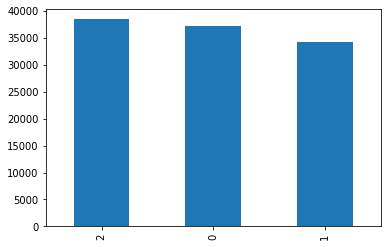

In [11]:
train_data["label"].value_counts().plot(kind="bar")

In [12]:
class_weight = len(train_data["label"]) / train_data["label"].value_counts()
class_weight /= class_weight.sum()
class_weight = dict(class_weight)
class_weight

{2: 0.3165196686886762, 0: 0.32727167595322115, 1: 0.3562086553581027}

## Building Model

In [13]:
def build_model():
    input_ids = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(CFG.sequence_length,), dtype=tf.int32, name="attention_mask")
    inputs = [input_ids, attention_mask]
    embedding = encoder(inputs)[0]
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(embedding)
    vector = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    dropouts = []
    for i in range(5):
        dropout = tf.keras.layers.Dropout(0.05 * (i + 1))(vector)
        dropout_output = tf.keras.layers.Dense(128, activation="swish")(dropout)
        dropouts.append(dropout_output)
    vector = tf.keras.layers.Average()(dropouts)
    output = tf.keras.layers.Dense(3, activation='softmax')(vector)
      
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 

In [14]:
with strategy.scope():
    model = build_model()
    model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tfxlm_roberta_model[0][0]    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


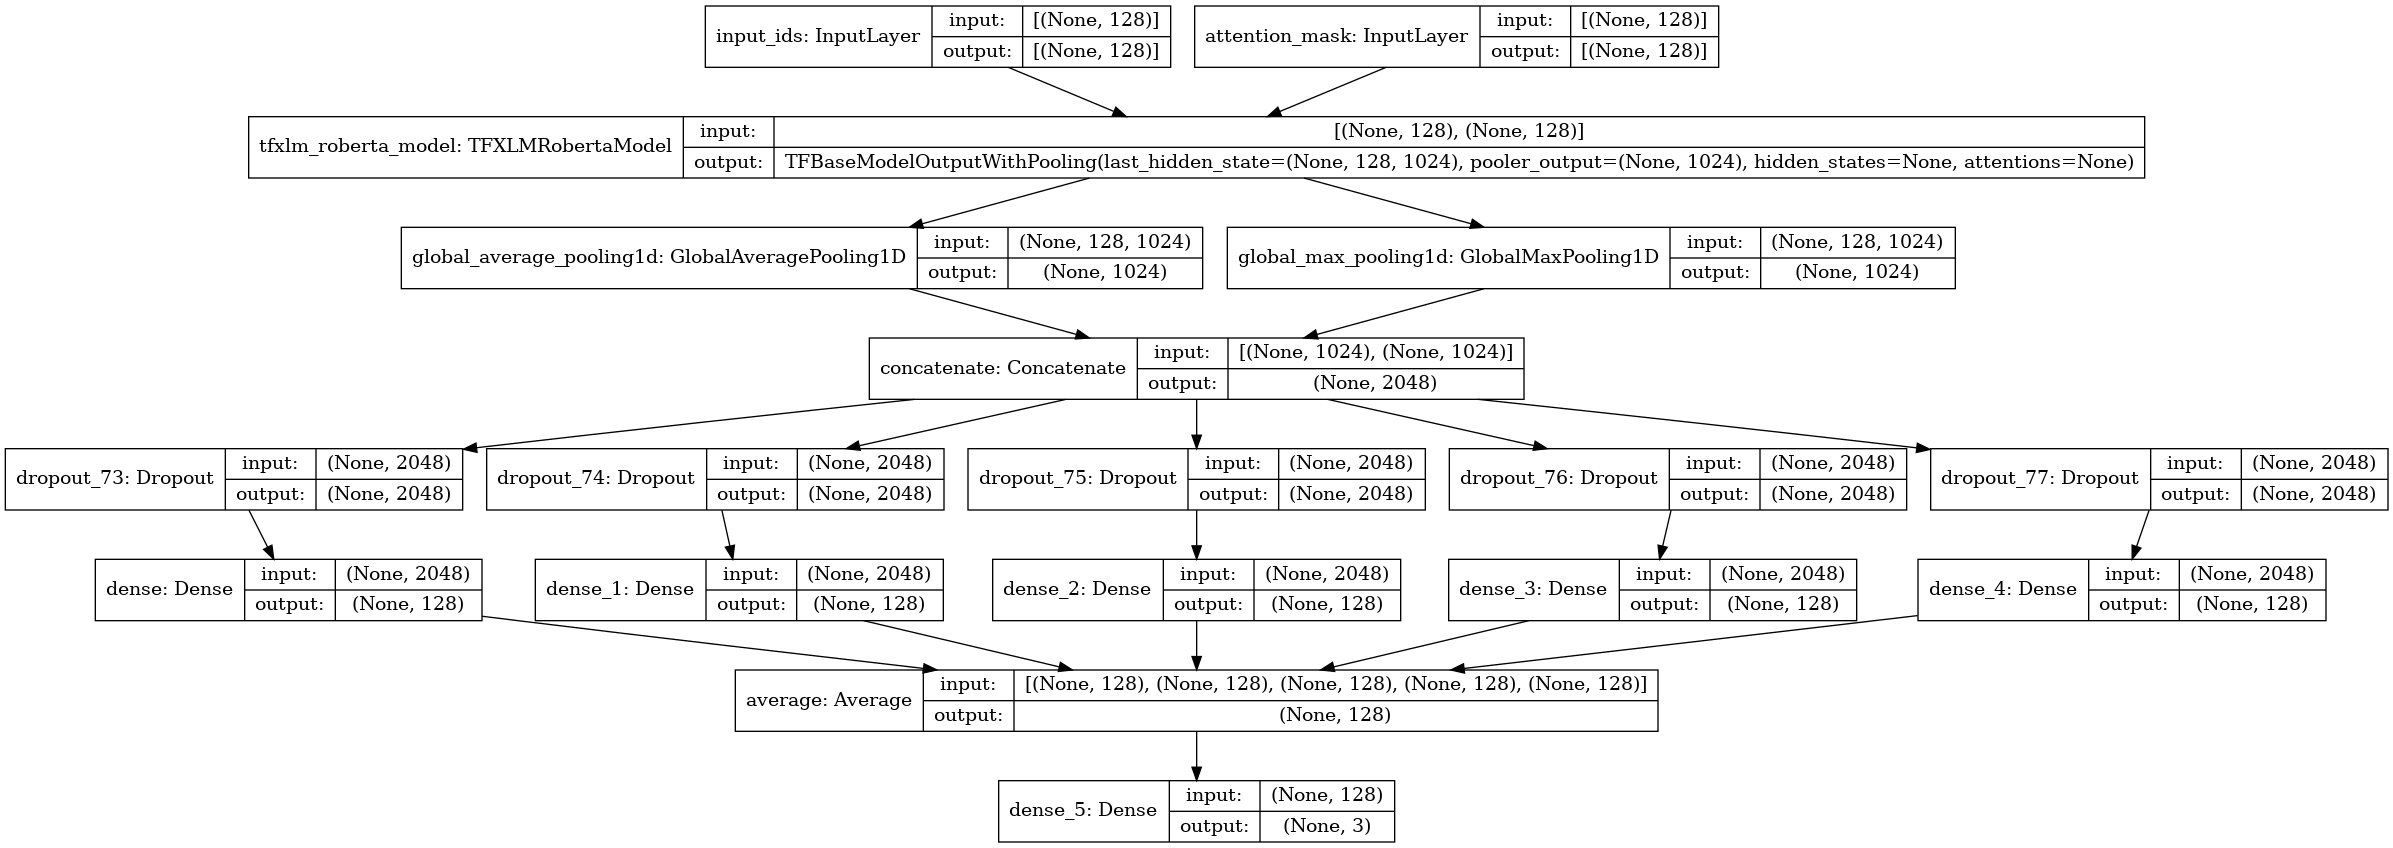

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


857/857 [==============================] - 387s 285ms/step - loss: 0.0880 - accuracy: 0.9069 - val_loss: 0.2277 - val_accuracy: 0.9301
Epoch 2/20
857/857 [==============================] - 305s 264ms/step - loss: 0.0544 - accuracy: 0.9466 - val_loss: 0.2445 - val_accuracy: 0.9236
Epoch 3/20
857/857 [==============================] - 226s 264ms/step - loss: 0.0387 - accuracy: 0.9622 - val_loss: 0.2919 - val_accuracy: 0.9175
Epoch 4/20
857/857 [==============================] - 226s 263ms/step - loss: 0.0311 - accuracy: 0.9696 - val_loss: 0.3186 - val_accuracy: 0.9193
Epoch 5/20
857/857 [==============================] - 226s 263ms/step - loss: 0.0240 - accuracy: 0.9769 - val_loss: 0.3699 - val_accuracy: 0.9180
Epoch 6/20
857/857 [==============================] - 226s 264ms/step - loss: 0.0198 - accuracy: 0.9804 - val_loss: 0.3181 - val_accuracy: 0.9262


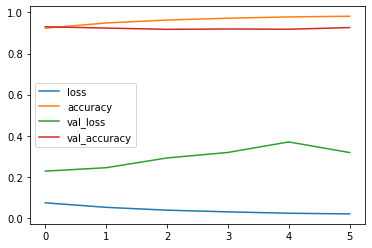

In [16]:
with strategy.scope():
    steps_per_epoch = train_data.shape[0] // CFG.batch_size
    validation_steps = valid_data.shape[0] // CFG.batch_size
    es = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_accuracy")
    checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True, save_weights_only=True, restore_best_weights=True)
    history = model.fit(
        train_ds, 
        epochs = 20, 
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        validation_data=valid_ds,
        class_weight=class_weight,
        callbacks=[es, checkpoint]
    )
    pd.DataFrame(history.history).plot()

## Create Submission file

In [17]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test, tokenizer)
test_ds = tf.data.Dataset.from_tensor_slices((test_input)).batch(CFG.batch_size)
predictions = np.argmax(model.predict(test_ds), axis=1)
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.to_csv("submission.csv", index = False)
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
